Importing the necessary modules:

In [39]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import zscore

Reading the dataset from csv-file:

In [40]:
dataset = pd.read_csv("flat_info_train.csv")

Some brief info about features' count and datatype

In [41]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16623 entries, 0 to 16622
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              16623 non-null  int64  
 1   name                            16614 non-null  object 
 2   host_id                         16623 non-null  int64  
 3   host_name                       16609 non-null  object 
 4   neighbourhood                   16623 non-null  object 
 5   latitude                        16623 non-null  float64
 6   longitude                       16623 non-null  float64
 7   room_type                       16623 non-null  object 
 8   minimum_nights                  16623 non-null  int64  
 9   number_of_reviews               16623 non-null  int64  
 10  last_review                     11404 non-null  object 
 11  reviews_per_month               11404 non-null  float64
 12  calculated_host_listings_count  

First 5 records in the dataset:

In [42]:
dataset.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,36378153,BCN life - Habitación,96039422,Rogerio,la Sagrera,41.42058,2.18816,Private room,31,0,NaN,NaN,1,365,13
1,26940439,Two Bedroom Apartment next to Sagrada Familia,98330509,Apart-Suites,la Sagrada Família,41.40149,2.17145,Entire home/apt,2,1,2020-10-26,0.28,5,279,141
2,42962582,"Hostal Nitzs BCN, Small Double w/ Shared Bathroom",341323870,Hostal Nitzs BCN,el Barri Gòtic,41.38211,2.17781,Private room,1,28,2020-10-22,3.87,5,365,999
3,36423530,GRAN Apto.Centro BCN. 5HAB. 3 BAÑOS Eixample,36438736,Dessy,l'Antiga Esquerra de l'Eixample,41.38985,2.15507,Entire home/apt,2,10,2020-02-09,0.51,1,225,289
4,23931051,Lucuma - Nice apartment at 7 min. walk of Ramb...,175453328,Amarantha,Sant Gervasi - Galvany,41.39416,2.14736,Entire home/apt,1,1,2018-09-30,0.03,12,332,86


There are many null values in reviews_per_month feature. It's a problem cause prediction model can not operate with null values. Let's see what we can do. For the first view it seems like null value corresponds to the case when there aren't any reviews, so maybe we can substitute null value to 0. Let's make sure in it by showing the records with null values in reviews_per_month feature:

In [43]:
dataset_with_null_values = dataset[dataset.reviews_per_month.isnull()]

In [44]:
dataset_with_null_values.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,36378153,BCN life - Habitación,96039422,Rogerio,la Sagrera,41.42058,2.18816,Private room,31,0,NaN,NaN,1,365,13
5,38370874,☼A Lovely Home of Barceloneta ☼,239550764,Clarice,la Barceloneta,41.38033,2.18745,Entire home/apt,32,0,NaN,NaN,30,179,41
11,45251736,habitacion privada en pleno centro de Barcelona,351928383,Sandra,el Fort Pienc,41.39574,2.18189,Private room,5,0,NaN,NaN,1,365,25
13,32126261,Single_perfect_cozy_room,12617302,Tom’s Team,"Sant Pere, Santa Caterina i la Ribera",41.38630,2.18161,Private room,30,0,NaN,NaN,14,0,15
14,40072766,amazinng born,309125199,Pratchaya,"Sant Pere, Santa Caterina i la Ribera",41.38442,2.18269,Entire home/apt,33,0,NaN,NaN,1,1,55


In [45]:
dataset_with_null_values[dataset_with_null_values.reviews_per_month.isnull() & dataset_with_null_values.number_of_reviews != 0]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price


Yes! There aren't any records with null value in reviews_per_month and non zero value in number_of_reviews. Our initial assunption was correct, so we can substitute the null values to 0 for reviews_per_month:

In [46]:
dataset["reviews_per_month"].fillna(value=0, inplace=True)

Some important statistical characteristics of the numeric features in the dataset:

In [47]:
dataset.describe()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
count,1.662300e+04,1.662300e+04,16623.000000,16623.000000,16623.000000,16623.000000,16623.000000,16623.000000,16623.000000,16623.000000
mean,2.654588e+07,1.133888e+08,41.392089,2.167271,12.636828,31.809060,0.664800,15.896228,181.527041,104.433977
std,1.454316e+07,1.155974e+08,0.014690,0.017757,31.399149,63.500847,1.040547,32.263607,143.775690,425.244484
min,1.867400e+04,3.073000e+03,41.349780,2.084030,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.481720e+07,9.356126e+06,41.380580,2.156535,1.000000,0.000000,0.000000,1.000000,9.000000,34.000000
50%,2.786688e+07,6.194019e+07,41.389500,2.168120,3.000000,3.000000,0.170000,3.000000,180.000000,55.000000
75%,4.014661e+07,2.055251e+08,41.401870,2.177870,30.000000,33.000000,0.940000,14.000000,333.000000,95.000000
max,4.810382e+07,3.855933e+08,41.467920,2.222340,1124.000000,786.000000,15.540000,182.000000,365.000000,11500.000000


As we can see, there are some features, that only duplicates the information from other features and we don't get any insides with them. So we can just drop unnesesarry features. 
They are: record id, host id. Also we can delete number_of_reviews and last_review from the dataset because reviews_per_month is calculated as difference in months between present date and last_review date divided by the number_of_reviews. Futhermore, we can get rid of calculated_host_listings_count because it only indicates the number of occurences of the corresponding host in the dataset. And also we can drop features name and host_name

In [48]:
dataset = dataset.drop(columns=["id", "name", "host_id", "host_name", "number_of_reviews", "last_review", "calculated_host_listings_count", "neighbourhood"])

In [49]:
dataset

,latitude,longitude,room_type,minimum_nights,reviews_per_month,availability_365,price
0,41.42058,2.18816,Private room,31,0.00,365,13
1,41.40149,2.17145,Entire home/apt,2,0.28,279,141
2,41.38211,2.17781,Private room,1,3.87,365,999
3,41.38985,2.15507,Entire home/apt,2,0.51,225,289
4,41.39416,2.14736,Entire home/apt,1,0.03,332,86
...,...,...,...,...,...,...,...
16618,41.38256,2.16736,Private room,2,2.14,161,18
16619,41.37805,2.17758,Private room,2,1.93,0,50
16620,41.39776,2.14171,Entire home/apt,32,0.39,348,80
16621,41.41206,2.17018,Private room,3,0.51,101,50


In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16623 entries, 0 to 16622
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           16623 non-null  float64
 1   longitude          16623 non-null  float64
 2   room_type          16623 non-null  object 
 3   minimum_nights     16623 non-null  int64  
 4   reviews_per_month  16623 non-null  float64
 5   availability_365   16623 non-null  int64  
 6   price              16623 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 909.2+ KB


We've solved all the problems with null values, let's see the histograms of frequency distribution for the left features:

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>],
       [<AxesSubplot:title={'center':'availability_365'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

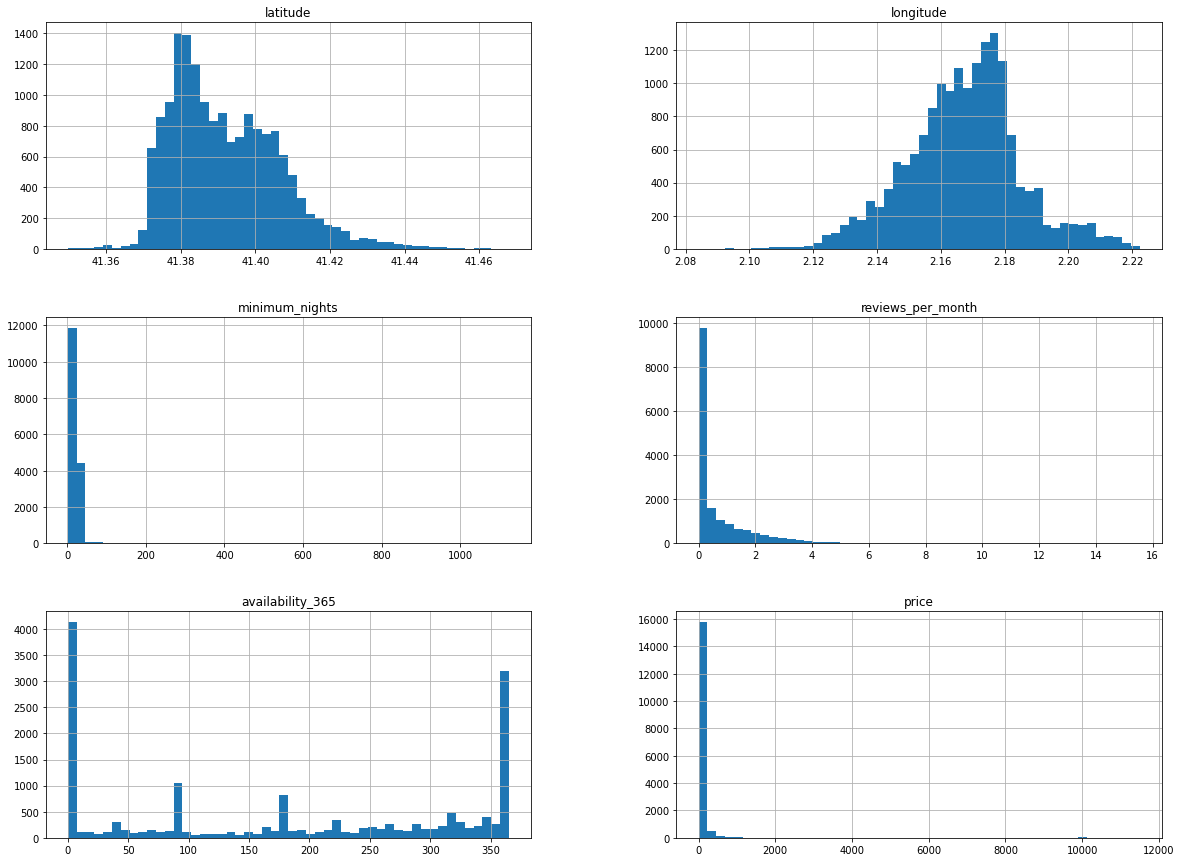

In [51]:
dataset.hist(bins=50, figsize=(20,15))

For the above diagrams we can observe the outliers in numerical data, which we should get rid of because outliers make the results of prediction model worse. To do it, we will use the standard outlier detector with interquartile range (IRQ). So we detect outliers in each numerical feature if their values are not in the interval [Q1 - 1.5 * IQR; Q3 + 1.5 * IQR], where Q1 equals to the first quartile (25th percentile) and Q3 equals to the third quartile (75th percentile)

In [52]:
def get_filtered_entries(dataset):
    Q1 = np.percentile(dataset, 25, axis=0)
    Q3 = np.percentile(dataset, 75, axis=0)
    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    return ((dataset >= low_lim) & (dataset <= up_lim)).all(axis=1)

In [53]:
numerical_features = [column for column in dataset.columns if dataset[column].dtype != "object"]
dataset = dataset[get_filtered_entries(dataset[numerical_features])]

Let's see the filtered dataset without outliers:

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>],
       [<AxesSubplot:title={'center':'availability_365'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

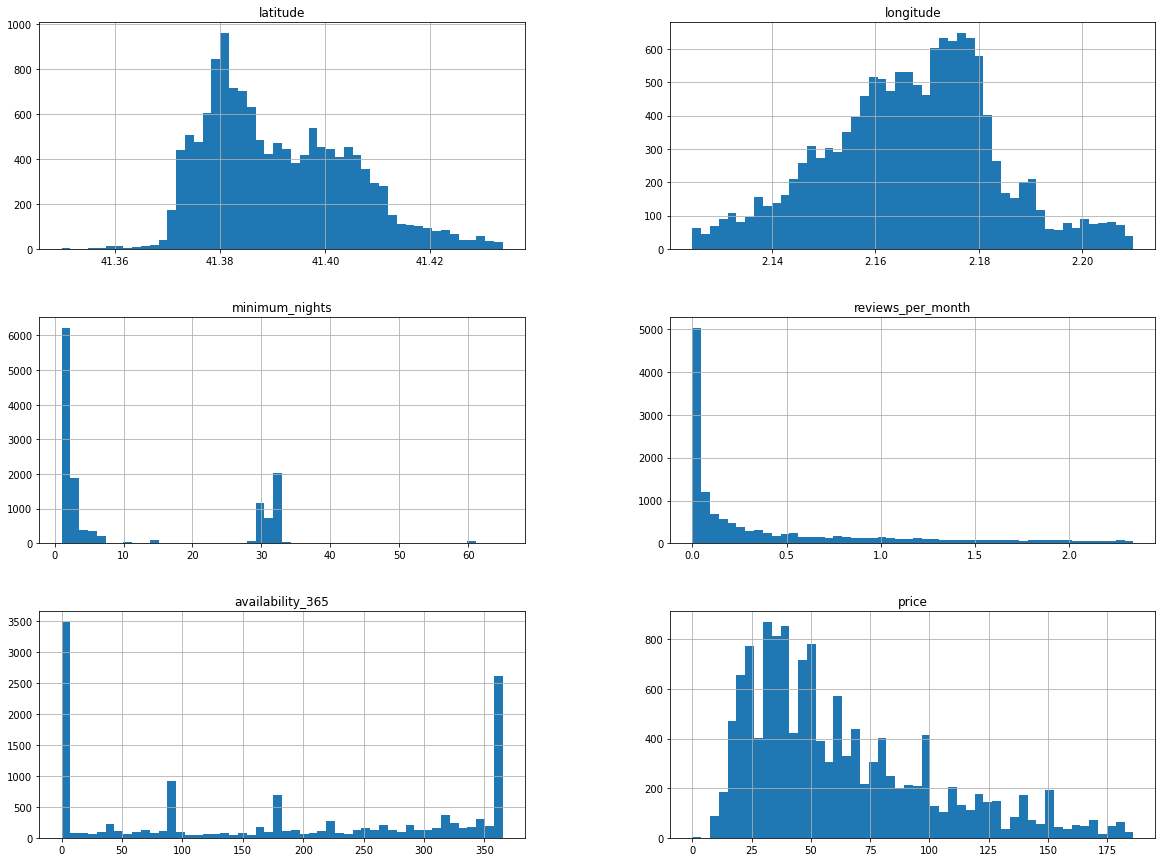

In [54]:
dataset.hist(bins=50, figsize=(20,15))

Much better! Our data now has less variation and therefore became more predictable.

Now let's see the price distribution depending on the the geographical position of apartments. Firstly we'll observe the frequency of the ads' appearances on the different geopositions:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

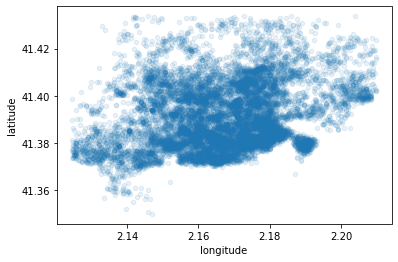

In [55]:
dataset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

We can see that most advertisements corresponds to the southern part of the city

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

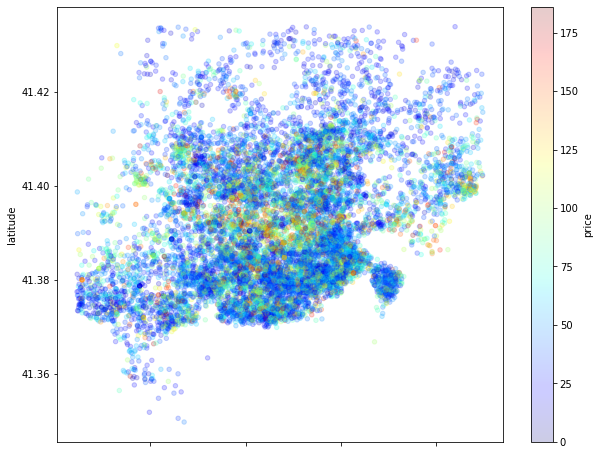

In [56]:
dataset.plot(kind="scatter", x="longitude", y="latitude", xlabel="longitude", ylabel="latitude",alpha=0.2,
    figsize=(10,8),c="price", cmap=plt.get_cmap("jet"), colorbar=True)

When we add price distribution, there is one more insight: the highest prices are located in the geographical centre of data. Maybe it is the city centre, then it seems reasonable cause the infrastructure is more developed in the city centre, than in other districts.

Now we can look at the correlation matrix for the numerical features of our data:

In [57]:
corr_matrix = dataset.corr()
corr_matrix

,latitude,longitude,minimum_nights,reviews_per_month,availability_365,price
latitude,1.000000,0.266160,-0.040868,0.004094,-0.016069,-0.013368
longitude,0.266160,1.000000,0.035678,0.013392,0.000073,0.015761
minimum_nights,-0.040868,0.035678,1.000000,-0.346925,0.174943,-0.121844
reviews_per_month,0.004094,0.013392,-0.346925,1.000000,-0.007708,0.083047
availability_365,-0.016069,0.000073,0.174943,-0.007708,1.000000,0.098082
price,-0.013368,0.015761,-0.121844,0.083047,0.098082,1.000000


This matrix is symmetric and it shows the linear dependence between different features. We can see some dependence between longitude and longitude, but it doesn't show any insights. Unlike geographical features, we can observe some inverse dependence between minimum_nights and reviews_per_month.
It means that people usually check more advertisements for the short-term rent. And also there is positive dependence between availability_365 and reviews_per_month, which means that apartments for the short-term rent are usually more available throughout the year. Probably the most important part is the inverse connection between price and minimum_nights, that means the price is usually higher for the short-term rent.

Next we'll see the price - room_type distribution from the category plot:

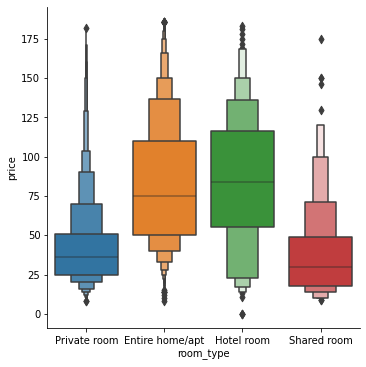

In [58]:
sns.catplot(x="room_type", y="price", kind="boxen", data=dataset)

This diagram shows us that entire appartments and hotel room cost more than just rooms in appartments. And in its own turn private room costs more than shared room.

Let's check our dataset once again:

In [59]:
dataset

,latitude,longitude,room_type,minimum_nights,reviews_per_month,availability_365,price
0,41.42058,2.18816,Private room,31,0.00,365,13
1,41.40149,2.17145,Entire home/apt,2,0.28,279,141
4,41.39416,2.14736,Entire home/apt,1,0.03,332,86
5,41.38033,2.18745,Entire home/apt,32,0.00,179,41
6,41.37488,2.15772,Private room,2,0.18,365,35
...,...,...,...,...,...,...,...
16618,41.38256,2.16736,Private room,2,2.14,161,18
16619,41.37805,2.17758,Private room,2,1.93,0,50
16620,41.39776,2.14171,Entire home/apt,32,0.39,348,80
16621,41.41206,2.17018,Private room,3,0.51,101,50


The final data prepraration part will be standard scaling for numerical features (for each feature substracting the mean and then divide by standard deviation to decrease data variation and set mean to 0) and one-hot encoding to transform the categorial features as binary vector with only one 1 and other zeros elements of vector. We do the one-hot encoding cause the prediction model can not handle the text categorial info:

In [60]:
num_attribs = ["latitude", "longitude", "minimum_nights", "reviews_per_month", "availability_365"]
cat_attribs = ["room_type"]
full_pipeline = ColumnTransformer([
 ("num", StandardScaler(), num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
dataset_prepared = full_pipeline.fit_transform(dataset)

To create the prediction model we should divide our data in the train and test parts. On the train data the machine learning algorithms will modify its parameters to fit the data as best as possible and on the train data we will check the quality of algorithms' work (on the new data, which they don't see before). But beforehand let's distinguish the target variable of price (y) and training variables (X)

In [61]:
X = dataset_prepared[:, :-1]

In [62]:
y = dataset.iloc[:, -1]

Let's split our data on the train and test parts, where 20% of all data will be for testing

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

And we can try different algorithms to predict the rent price. In my example, I will use the LinearRegression, DecisionTreeRegressor and RandomForestRegressor models. As the error function I'll use the mean squared error.

In [64]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [65]:
from sklearn.metrics import mean_squared_error
price_predictions = lin_reg.predict(X_test)
lin_mse = mean_squared_error(price_predictions, y_test)

In [66]:
lin_mse

936.1550131074722

In [67]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
price_predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(price_predictions, y_test)

In [68]:
tree_mse

1577.4701339784147

In [69]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
price_predictions = forest_reg.predict(X_test)
forest_mse = mean_squared_error(price_predictions, y_test)

In [70]:
forest_mse

787.627384565104

As we can see, the ensemble method of RandomForestRegressor which contains many desicion trees makes the best results. So we'll leave him for the price prediction for the test file:

In [71]:
dataset_test = pd.read_csv("flat_info_test.csv")

In [72]:
dataset_test_filled_null = dataset_test.copy()

In [73]:
dataset_test_filled_null["reviews_per_month"].fillna(value=0, inplace=True)

In [74]:
dataset_test_prepared = full_pipeline.fit_transform(dataset_test_filled_null)
X = dataset_test_prepared[:, :-1]
y = dataset_test_filled_null.iloc[:, -1]
forest_reg.fit(X, y)
price_predictions = forest_reg.predict(X)

In [75]:
result = pd.concat([dataset_test, pd.DataFrame(price_predictions, columns=["price"])], axis=1)

Create output file with predicted prices for rent:

In [76]:
result.to_csv("output.csv", index=False)